ID: 11508393
NAME: Ping-Chun Lee

# 5222: Feature Engineering ICE#1
## Rubric


1. Complete and proper Github Submission (10%)
2. Complete and proper submission to Canvas (5%)
3. Source Code (50%)
4. Explaining the answers (30%)
5. Commenting, formatting, and visualizing your code properly and timely submission (5%)

Please goto https://towardsdatascience.com/text-classification-in-python-dd95d264c802 and follow the article. 
This article is for text classification using python. 
Their Github is available at https://github.com/miguelfzafra/Latest-News-Classifier/tree/master/0.%20Latest%20News%20Classifier. 
Follow their step 00,01,02,03 and 04. Use the same workbook to execute your code


# data exploratory

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
sns.set_style("whitegrid")
import altair as alt
#alt.renderers.enable("notebook")

import warnings
warnings.filterwarnings("ignore")

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2

import numpy as np

In [ ]:
df = pd.read_csv("News_dataset.csv", sep=';')
df.head()

,File_Name,Content,Category,Complete_Filename
0,001.txt,Ad sales boost Time Warner profit\n\nQuarterly...,business,001.txt-business
1,002.txt,Dollar gains on Greenspan speech\n\nThe dollar...,business,002.txt-business
2,003.txt,Yukos unit buyer faces loan claim\n\nThe owner...,business,003.txt-business
3,004.txt,High fuel prices hit BA's profits\n\nBritish A...,business,004.txt-business
4,005.txt,Pernod takeover talk lifts Domecq\n\nShares in...,business,005.txt-business


In [ ]:
bars = alt.Chart(df).mark_bar(size=50).encode(
    x=alt.X("Category"),
    y=alt.Y("count():Q", axis=alt.Axis(title='Number of articles')),
    tooltip=[alt.Tooltip('count()', title='Number of articles'), 'Category'],
    color='Category'
)
text = bars.mark_text(
    align='center', 
    baseline='bottom').encode(
        text='count()'
    )
(bars+text).interactive().properties(
    height=300,
    width=700,
    title="Number of articles in each category",
)



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df['id']=1
df2=pd.DataFrame(df.groupby('Category').count()['id']).reset_index()

bars = alt.Chart(df2).mark_bar(size=10).encode(
    x=alt.X("Category"),
    y=alt.Y("PercentOfTotal:Q", axis=alt.Axis(format='.0%', title='% of Articles')),
    tooltip=[alt.Tooltip('count()', title='Number of articles'), 'Category'],
    color='Category'
).transform_window(
    TotalArticles='sum(id)',
    frame=[None, None]
).transform_calculate(
    PercentOfTotal="datum.id / datum.TotalArticles"
)
text = bars.mark_text(
    align='center', 
    baseline='bottom').encode(
        text=alt.Text('PercentOfTotal:Q', format='.1%')
    )
(bars+text).interactive().properties(
    height=300,
    width=700,
    title="% of articles in each category",
)

alt.LayerChart(...)

In [ ]:
df['News_length'] = df['Content'].str.len()
df.head()

,File_Name,Content,Category,Complete_Filename,id,News_length
0,001.txt,Ad sales boost Time Warner profit\n\nQuarterly...,business,001.txt-business,1,2559
1,002.txt,Dollar gains on Greenspan speech\n\nThe dollar...,business,002.txt-business,1,2251
2,003.txt,Yukos unit buyer faces loan claim\n\nThe owner...,business,003.txt-business,1,1551
3,004.txt,High fuel prices hit BA's profits\n\nBritish A...,business,004.txt-business,1,2411
4,005.txt,Pernod takeover talk lifts Domecq\n\nShares in...,business,005.txt-business,1,1569


Text(0.5, 1.0, 'News length distribution')

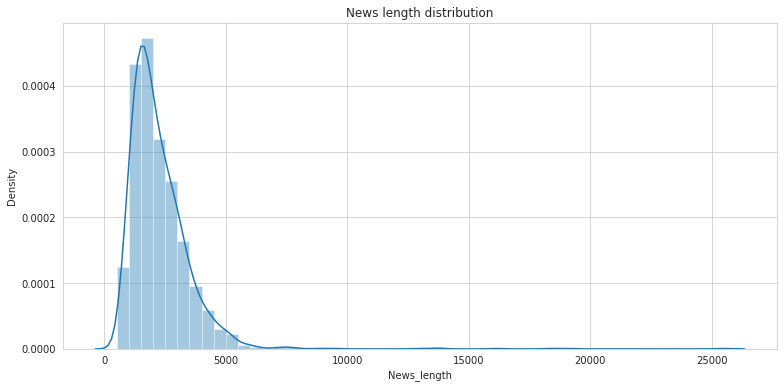

In [ ]:
plt.figure(figsize=(12.8, 6))
sns.distplot(df['News_length']).set_title('News length distribution')

In [ ]:
df['News_length'].describe()

count     2225.000000
mean      2264.790562
std       1364.305951
min        502.000000
25%       1447.000000
50%       1966.000000
75%       2803.000000
max      25484.000000
Name: News_length, dtype: float64

Text(0.5, 1.0, 'News length distribution')

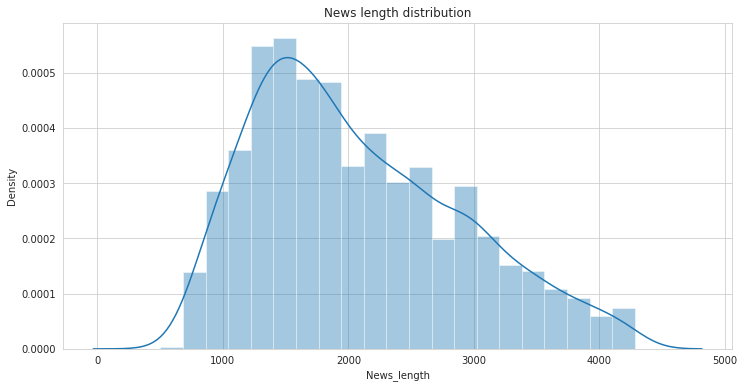

In [ ]:
quantile_95 = df['News_length'].quantile(.95)
df_95 = df[df['News_length']<quantile_95]
plt.figure(figsize=(12,6))
sns.distplot(df_95['News_length']).set_title('News length distribution')

In [ ]:
df_more10k = df[df['News_length']>10000]
len(df_more10k)

7

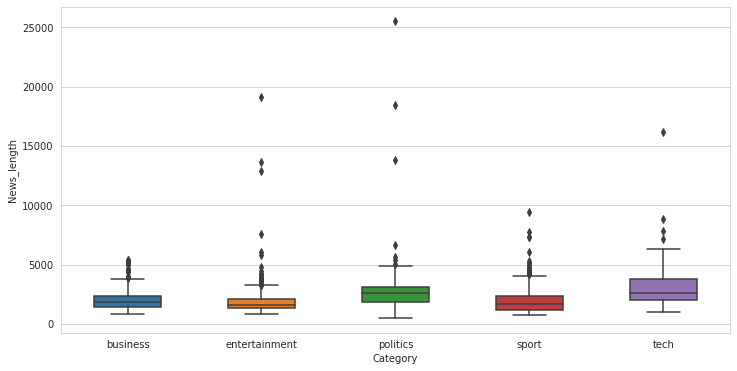

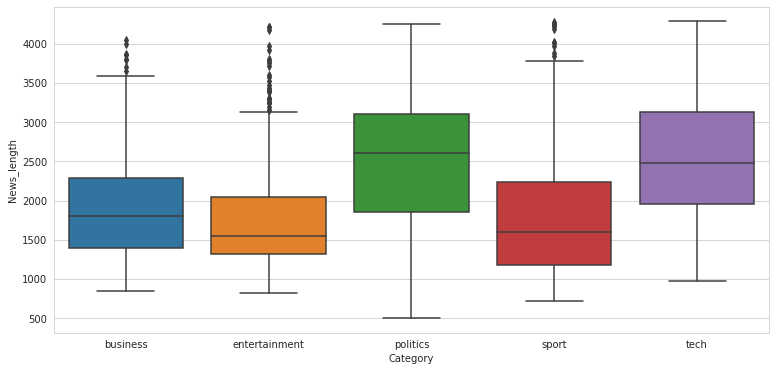

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Category', y='News_length', width=.5)
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df_95, x='Category', y='News_length');

# Feature Engineering

In [ ]:
df['Content_Parsed_1'] = df['Content'].str.replace("\r", " ")
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("\n", " ")
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("    ", " ")
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace('"', '')
df['Content_Parsed_2'] = df['Content_Parsed_1'].str.lower()
punctuation_signs = list("?:!.,;")
df['Content_Parsed_3'] = df['Content_Parsed_2']

for i in punctuation_signs:
  df['Content_Parsed_3'] = df['Content_Parsed_3'].str.replace(i, '')
df['Content_Parsed_4'] = df['Content_Parsed_3'].str.replace("'s", "")  

In [ ]:
# Downloading punkt and wordnet from NLTK
nltk.download('punkt')
print("------------------------------------------------------------")
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


------------------------------------------------------------


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()
nrows = len(df)
lemmatized_text_list = []

for row in range(nrows):
  lemmatized_list = []

  text = df.loc[row]['Content_Parsed_4']
  text_words = text.split(" ")
  for word in text_words:
    lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))

  lemmatized_text = " ".join(lemmatized_list)

  lemmatized_text_list.append(lemmatized_text)

df['Content_Parsed_5'] = lemmatized_text_list

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = list(stopwords.words('english'))

df['Content_Parsed_6'] = df['Content_Parsed_5']
for stop_word in stop_words:
  regex_stopword = r"\b" + stop_word + r"\b"
  df['Content_Parsed_6'] = df['Content_Parsed_6'].str.replace(regex_stopword, '')

In [ ]:
list_columns = ["File_Name", "Category", "Complete_Filename", "Content", "Content_Parsed_6"]
df = df[list_columns]
df = df.rename(columns={'Content_Parsed_6': 'Content_Parsed'})
df.head()

,File_Name,Category,Complete_Filename,Content,Content_Parsed
0,001.txt,business,001.txt-business,Ad sales boost Time Warner profit\n\nQuarterly...,ad sales boost time warner profit quarterly p...
1,002.txt,business,002.txt-business,Dollar gains on Greenspan speech\n\nThe dollar...,dollar gain greenspan speech dollar hit h...
2,003.txt,business,003.txt-business,Yukos unit buyer faces loan claim\n\nThe owner...,yukos unit buyer face loan claim owners emb...
3,004.txt,business,004.txt-business,High fuel prices hit BA's profits\n\nBritish A...,high fuel price hit ba profit british airways...
4,005.txt,business,005.txt-business,Pernod takeover talk lifts Domecq\n\nShares in...,pernod takeover talk lift domecq share uk dr...


In [ ]:
category_codes={
    'business': 0,
    'entertainment':1,
    'politics':2,
    'sport':3,
    'tech':4
}
df['Category_Code'] = df['Category']
df = df.replace({'Category_Code':category_codes})
df.head()

,File_Name,Category,Complete_Filename,Content,Content_Parsed,Category_Code
0,001.txt,business,001.txt-business,Ad sales boost Time Warner profit\n\nQuarterly...,ad sales boost time warner profit quarterly p...,0
1,002.txt,business,002.txt-business,Dollar gains on Greenspan speech\n\nThe dollar...,dollar gain greenspan speech dollar hit h...,0
2,003.txt,business,003.txt-business,Yukos unit buyer faces loan claim\n\nThe owner...,yukos unit buyer face loan claim owners emb...,0
3,004.txt,business,004.txt-business,High fuel prices hit BA's profits\n\nBritish A...,high fuel price hit ba profit british airways...,0
4,005.txt,business,005.txt-business,Pernod takeover talk lifts Domecq\n\nShares in...,pernod takeover talk lift domecq share uk dr...,0


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['Content_Parsed'], df['Category_Code'], test_size=0.15, random_state=8)

In [ ]:
ngram_range=(1, 2)
min_df = 10
max_df = 1.
max_features=300

In [ ]:
tfidf = TfidfVectorizer(encoding='utf-8', ngram_range=ngram_range, stop_words=None, lowercase=False, max_df=max_df,
                        min_df=min_df, max_features=max_features, norm='l2', sublinear_tf=True)
features_train = tfidf.fit_transform(x_train).toarray()
labels_train=y_train
print(features_train.shape)
features_test = tfidf.transform(x_test).toarray()
labels_test=y_test
print(features_test.shape)

(1891, 300)
(334, 300)


In [ ]:
for product, c_id in sorted(category_codes.items()):
  features_chi2 = chi2(features_train,  labels_train==c_id)
  indices = np.argsort(features_chi2[0])
  feature_names=np.array(tfidf.get_feature_names())[indices]
  unigrams=[v for v in feature_names if len(v.split(' ')) == 1]
  bigrams=[v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}' category:".format(product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
  print("")

# 'business' category:
  . Most correlated unigrams:
. market
. price
. economy
. growth
. bank
  . Most correlated bigrams:
. last year
. year old

# 'entertainment' category:
  . Most correlated unigrams:
. tv
. music
. star
. award
. film
  . Most correlated bigrams:
. mr blair
. prime minister

# 'politics' category:
  . Most correlated unigrams:
. minister
. blair
. party
. election
. labour
  . Most correlated bigrams:
. prime minister
. mr blair

# 'sport' category:
  . Most correlated unigrams:
. win
. side
. game
. team
. match
  . Most correlated bigrams:
. say mr
. year old

# 'tech' category:
  . Most correlated unigrams:
. digital
. technology
. computer
. software
. users
  . Most correlated bigrams:
. year old
. say mr



# random search for hyperparameter

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit

In [56]:
model = [RandomForestClassifier(random_state=8), 
        svm.SVC(random_state=8), 
        KNeighborsClassifier(), 
        MultinomialNB(), 
        LogisticRegression(random_state=8), 
        GradientBoostingClassifier(random_state=8)]
for i in model:
  pprint(i.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 8,
 'verbose': 0,
 'warm_start': False}
{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 8,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}
{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}
{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}
{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scali

Random Forester

In [57]:
# random search model parameter
#Random Forester
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}
random_search = RandomizedSearchCV(estimator=model[0],
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)
random_search.fit(features_train, labels_train)
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
The best hyperparameters from Random Search are:
{'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': False}

The mean accuracy of a model with these hyperparameters is:
0.9434181068095491


In [60]:
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)
bootstrap = [False]
max_depth = [30, 40, 50]
max_features = ['sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [5, 10, 15]
n_estimators = [600]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=model[0], 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

best_rfc = grid_search.best_estimator_
best_rfc

Fitting 3 folds for each of 27 candidates, totalling 81 fits
The best hyperparameters from Grid Search are:
{'bootstrap': False, 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 600}

The mean accuracy of a model with these hyperparameters is:
0.9434666666666667


RandomForestClassifier(bootstrap=False, max_depth=40, max_features='sqrt',
                       min_samples_split=5, n_estimators=600, random_state=8)

SVM

In [61]:
# SVM
random_grid={
    'C':[.0001, .001, .01],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [.0001, .001, .01, .1, 1, 10, 100],
    'degree': [1, 2, 3, 4, 5],
    'probability': [True]
}
random_search = RandomizedSearchCV(estimator=model[1],
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)
random_search.fit(features_train, labels_train)

print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
The best hyperparameters from Random Search are:
{'probability': True, 'kernel': 'poly', 'gamma': 10, 'degree': 4, 'C': 0.01}

The mean accuracy of a model with these hyperparameters is:
0.9217358857612424


In [62]:
# Create the parameter grid based on the results of random search 
C = [.0001, .001, .01, .1]
degree = [3, 4, 5]
gamma = [1, 10, 100]
probability = [True]

param_grid = [
  {'C': C, 'kernel':['linear'], 'probability':probability},
  {'C': C, 'kernel':['poly'], 'degree':degree, 'probability':probability},
  {'C': C, 'kernel':['rbf'], 'gamma':gamma, 'probability':probability}
]

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=model[1], 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

best_svc = grid_search.best_estimator_
best_svc

Fitting 3 folds for each of 28 candidates, totalling 84 fits
The best hyperparameters from Grid Search are:
{'C': 0.1, 'kernel': 'linear', 'probability': True}

The mean accuracy of a model with these hyperparameters is:
0.9498666666666665


SVC(C=0.1, kernel='linear', probability=True, random_state=8)

KNN

In [63]:
# Create the parameter grid 
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 500, num = 100)]

param_grid = {'n_neighbors': n_neighbors}

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=model[2], 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
The best hyperparameters from Grid Search are:
{'n_neighbors': 6}

The mean accuracy of a model with these hyperparameters is:
0.9477333333333333


In [64]:
n_neighbors = [1,2,3,4,5,6,7,8,9,10,11]
param_grid = {'n_neighbors': n_neighbors}


cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

grid_search = GridSearchCV(estimator=model[2], 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

grid_search.fit(features_train, labels_train)

print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

best_knnc = grid_search.best_estimator_
best_knnc

Fitting 3 folds for each of 11 candidates, totalling 33 fits
The best hyperparameters from Grid Search are:
{'n_neighbors': 6}

The mean accuracy of a model with these hyperparameters is:
0.9477333333333333


KNeighborsClassifier(n_neighbors=6)

Naive Bayes

In [65]:
mnbc = model[3]

Multinomial LogReg

In [66]:
# C
C = [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 10)]

# multi_class
multi_class = ['multinomial']

# solver
solver = ['newton-cg', 'sag', 'saga', 'lbfgs']
 
# class_weight
class_weight = ['balanced', None]

# penalty
penalty = ['l2']

# Create the random grid
random_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

# First create the base model to tune
lrc = LogisticRegression(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=lrc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
The best hyperparameters from Random Search are:
{'solver': 'sag', 'penalty': 'l2', 'multi_class': 'multinomial', 'class_weight': 'balanced', 'C': 1.0}

The mean accuracy of a model with these hyperparameters is:
0.9566380734368057


In [67]:
# Create the parameter grid based on the results of random search 
C = [float(x) for x in np.linspace(start = 0.6, stop = 1, num = 10)]
multi_class = ['multinomial']
solver = ['sag']
class_weight = ['balanced']
penalty = ['l2']

param_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

# Create a base model
lrc = LogisticRegression(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=lrc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)


print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)


best_lrc = grid_search.best_estimator_
best_lrc

Fitting 3 folds for each of 10 candidates, totalling 30 fits
The best hyperparameters from Grid Search are:
{'C': 1.0, 'class_weight': 'balanced', 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag'}

The mean accuracy of a model with these hyperparameters is:
0.9685333333333332


LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   random_state=8, solver='sag')

Gradient Boosting Classifier

In [68]:
# n_estimators
n_estimators = [200, 800]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [10, 40]
max_depth.append(None)

# min_samples_split
min_samples_split = [10, 30, 50]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# learning rate
learning_rate = [.1, .5]

# subsample
subsample = [.5, 1.]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate,
               'subsample': subsample}

# First create the base model to tune
gbc = GradientBoostingClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=gbc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)


print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
The best hyperparameters from Random Search are:
{'subsample': 0.5, 'n_estimators': 800, 'min_samples_split': 30, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'learning_rate': 0.1}

The mean accuracy of a model with these hyperparameters is:
0.9545174787647053


In [69]:
# Create the parameter grid based on the results of random search 
max_depth = [5, 10, 15]
max_features = ['sqrt']
min_samples_leaf = [2]
min_samples_split = [50, 100]
n_estimators = [800]
learning_rate = [.1, .5]
subsample = [1.]

param_grid = {
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'subsample': subsample

}

# Create a base model
gbc = GradientBoostingClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=gbc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

best_gbc = grid_search.best_estimator_
best_gbc

Fitting 3 folds for each of 12 candidates, totalling 36 fits
The best hyperparameters from Grid Search are:
{'learning_rate': 0.1, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 100, 'n_estimators': 800, 'subsample': 1.0}

The mean accuracy of a model with these hyperparameters is:
0.9551999999999999


GradientBoostingClassifier(max_depth=10, max_features='sqrt',
                           min_samples_leaf=2, min_samples_split=100,
                           n_estimators=800, random_state=8)

# model train

In [70]:
best_rfc.fit(features_train, labels_train)
best_svc.fit(features_train, labels_train)
best_knnc.fit(features_train, labels_train)
mnbc.fit(features_train, labels_train)
best_lrc.fit(features_train, labels_train)
best_gbc.fit(features_train, labels_train)

GradientBoostingClassifier(max_depth=10, max_features='sqrt',
                           min_samples_leaf=2, min_samples_split=100,
                           n_estimators=800, random_state=8)

# classification report

In [78]:
best_model = [best_rfc, best_svc, best_knnc, mnbc, best_lrc, best_gbc]
train_acc_list = []
test_acc_list = []
for i in best_model:
  pred = i.predict(features_test)
  print(i)
  train_acc = accuracy_score(labels_train, i.predict(features_train))
  test_acc = accuracy_score(labels_test, pred)
  train_acc_list.append(train_acc)
  test_acc_list.append(test_acc)
  print("Train accuracy: ", train_acc)
  print("Test accuracy: ", test_acc)
  print("classification report")
  print(classification_report(labels_test, pred))
  print("")

RandomForestClassifier(bootstrap=False, max_depth=40, max_features='sqrt',
                       min_samples_split=5, n_estimators=600, random_state=8)
Train accuracy:  1.0
Test accuracy:  0.9311377245508982
classification report
              precision    recall  f1-score   support

           0       0.87      0.96      0.91        81
           1       0.90      0.94      0.92        49
           2       0.97      0.86      0.91        72
           3       0.99      0.96      0.97        72
           4       0.95      0.93      0.94        60

    accuracy                           0.93       334
   macro avg       0.93      0.93      0.93       334
weighted avg       0.93      0.93      0.93       334


SVC(C=0.1, kernel='linear', probability=True, random_state=8)
Train accuracy:  0.9592808038075092
Test accuracy:  0.9401197604790419
classification report
              precision    recall  f1-score   support

           0       0.88      0.98      0.92        81
           1   

In [83]:
d = {
    'Model': ["Random Forest", "SVM", "KNN", "Multinomial Naive Bayes", "Logistic Regression", "Gradient Boosting"],
     "Train accuracy": train_acc_list,
     "Test accuracy": test_acc_list
}
df_models_acc = pd.DataFrame(d)
df_models_acc.sort_values("Test accuracy", ascending=False)
#Choose SVM as this project's model because it similar train and test accuracy

,Model,Train accuracy,Test accuracy
5,Gradient Boosting,1.000000,0.946108
1,SVM,0.959281,0.940120
4,Logistic Regression,0.981491,0.940120
3,Multinomial Naive Bayes,0.953993,0.934132
0,Random Forest,1.000000,0.931138
2,KNN,0.959810,0.928144


# predict for autonomous cars news

After successfully implementing their code. Try to gather data from an online URL related to autonomous cars (your choice but a long article)
Use all techniques covered in the above code on the dataset that you have just created. 


news link: https://www.theverge.com/2022/9/7/23340725/tesla-model-y-five-star-safety-euro-ncap

news content

Tesla extended its five-star rating streak in Europe with the Model Y, the company announced. The electric crossover SUV earned top marks during safety tests conducted by the European New Car Assessment Programme (Euro NCAP), receiving the highest overall score among any vehicle tested under the agency’s more stringent test protocol.
The testing measures four areas: the vehicle’s ability to protect adults; its ability to protect children; the protection it provides vulnerable road users like cyclists and pedestrians; and its safety assistance features. The Model Y, made at Tesla’s new gigafactory in Berlin, scored a 97 percent in Adult Occupant Protection and a “near-perfect” 98 percent in Safety Assist, with full points for its lane support and new cabin camera-based driver monitoring system, Euro NCAP reports.
The agency also commended Tesla for its camera-only vision system, which it said “performs remarkably well” in preventing collisions with other cars, cyclists, and pedestrians.
“Tesla have shown that nothing but the best is good enough for them, and we hope to see them continue to aspire to that goal in the future,” Michiel van Ratingen, Euro NCAP’s secretary general, said in a statement.
Tesla has historically achieved high safety ratings thanks to its underlying architecture, which makes the car more rigid and better protects passengers. The location of the battery in the floor of the vehicle also gives the Model Y and other Tesla vehicles a lower center of gravity, which improves road stability and decreases the chances of a rollover. Tesla’s other three vehicles, the Model S, Model X, and Model 3, have also earned five-star ratings from Euro NCAP.
“Our team is dedicated to improving driving safety,” the company said in a blog post. “Achieving some of the highest safety scores ever awarded doesn’t give us pause — it motivates us to make some of the world’s safest vehicles even safer.”
In the US, it’s the same story. All four of Tesla’s vehicles have earned five-star ratings from the National Highway Traffic Safety Administration, the most recent going to the Model Y in 2021. NHTSA grades cars on a variety of crash test metrics, including frontal crashes (with subcategories for both the driver and passenger seats), side crashes (for crashes into both a barrier and a pole), and rollover scenarios — but not pedestrian and cyclist safety and not driver-assist technology (though that will soon change).
Notably, neither Euro NCAP nor NHTSA includes Tesla’s two driver-assist systems — Autopilot and Full Self-Driving (FSD) — in its testing protocols. Euro NCAP does take into account the automatic emergency braking system (AEB) and the lane-keep assist that prevents drivers from unintentionally drifting into another lane.
NHTSA is currently investigating nearly three dozen incidents in the US involving Autopilot. Earlier this year, the agency upgraded its probe into a dozen crashes involving stationary emergency vehicles, bringing Tesla one step closer to a possible recall. Tesla has yet to obtain regulatory approval for FSD in the European Union, which has a much higher bar to clear than the US.

In [126]:
news_content = "Tesla extended its five-star rating streak in Europe with the Model Y, the company announced. The electric crossover SUV earned top marks during safety tests conducted by the European New Car Assessment Programme (Euro NCAP), receiving the highest overall score among any vehicle tested under the agency’s more stringent test protocol. The testing measures four areas: the vehicle’s ability to protect adults; its ability to protect children; the protection it provides vulnerable road users like cyclists and pedestrians; and its safety assistance features. The Model Y, made at Tesla’s new gigafactory in Berlin, scored a 97 percent in Adult Occupant Protection and a “near-perfect” 98 percent in Safety Assist, with full points for its lane support and new cabin camera-based driver monitoring system, Euro NCAP reports. The agency also commended Tesla for its camera-only vision system, which it said “performs remarkably well” in preventing collisions with other cars, cyclists, and pedestrians. “Tesla have shown that nothing but the best is good enough for them, and we hope to see them continue to aspire to that goal in the future,” Michiel van Ratingen, Euro NCAP’s secretary general, said in a statement. Tesla has historically achieved high safety ratings thanks to its underlying architecture, which makes the car more rigid and better protects passengers. The location of the battery in the floor of the vehicle also gives the Model Y and other Tesla vehicles a lower center of gravity, which improves road stability and decreases the chances of a rollover. Tesla’s other three vehicles, the Model S, Model X, and Model 3, have also earned five-star ratings from Euro NCAP. “Our team is dedicated to improving driving safety,” the company said in a blog post. “Achieving some of the highest safety scores ever awarded doesn’t give us pause — it motivates us to make some of the world’s safest vehicles even safer.” In the US, it’s the same story. All four of Tesla’s vehicles have earned five-star ratings from the National Highway Traffic Safety Administration, the most recent going to the Model Y in 2021. NHTSA grades cars on a variety of crash test metrics, including frontal crashes (with subcategories for both the driver and passenger seats), side crashes (for crashes into both a barrier and a pole), and rollover scenarios — but not pedestrian and cyclist safety and not driver-assist technology (though that will soon change). Notably, neither Euro NCAP nor NHTSA includes Tesla’s two driver-assist systems — Autopilot and Full Self-Driving (FSD) — in its testing protocols. Euro NCAP does take into account the automatic emergency braking system (AEB) and the lane-keep assist that prevents drivers from unintentionally drifting into another lane. NHTSA is currently investigating nearly three dozen incidents in the US involving Autopilot. Earlier this year, the agency upgraded its probe into a dozen crashes involving stationary emergency vehicles, bringing Tesla one step closer to a possible recall. Tesla has yet to obtain regulatory approval for FSD in the European Union, which has a much higher bar to clear than the US."

#replace new line
news_content = news_content.replace("\r", " ")
news_content = news_content.replace("\n", " ")
#replace space
news_content = news_content.replace("    ", " ")
#replace quote
news_content = news_content.replace('“', '')
news_content = news_content.replace('”', '')
news_content = news_content.replace('—', '')
news_content = news_content.replace('-', '')
# change all letters to lower
news_content = news_content.lower()
# replace punctuation sign
punctuation_signs = list("?:!.,;()—")
for i in punctuation_signs:
  news_content = news_content.replace(i, '')
news_content = news_content.replace("’s", "")  

# do lemmatization
lemmatized_list = []
news_text_words = news_content.split(" ")
for word in news_text_words:
  lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
news_lemmatized_text = " ".join(lemmatized_list)  


# remove stop word
stop_words = list(stopwords.words('english'))

for stop_word in stop_words:
  regex_stopword = r"\b" + stop_word + r"\b"
  news_lemmatized_text = news_lemmatized_text.replace(regex_stopword, '')
news_lemmatized_text

'tesla extend its fivestar rat streak in europe with the model y the company announce the electric crossover suv earn top mark during safety test conduct by the european new car assessment programme euro ncap receive the highest overall score among any vehicle test under the agency more stringent test protocol the test measure four areas the vehicle ability to protect adults its ability to protect children the protection it provide vulnerable road users like cyclists and pedestrians and its safety assistance feature the model y make at tesla new gigafactory in berlin score a 97 percent in adult occupant protection and a nearperfect 98 percent in safety assist with full point for its lane support and new cabin camerabased driver monitor system euro ncap report the agency also commend tesla for its cameraonly vision system which it say perform remarkably well in prevent collisions with other cars cyclists and pedestrians tesla have show that nothing but the best be good enough for them a

In [135]:
# predict category using SVM we decided before
news_pd = pd.Series([news_lemmatized_text])
best_svc.predict(tfidf.transform(news_pd).toarray())

array([3])

The prediction result is "SPORT" news